# morpho_reconstruction
State variable reconstruction and model visualization

In [1]:
from neuron import h
from neuron.units import mV, ms
import numpy as np
import plotly
import matplotlib.pyplot as plt
from matplotlib import cm
import queue
import json
import gc

h.load_file("stdrun.hoc")
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")
h.load_file("stdrun.hoc")

1.0

In [2]:
def event_type2color(event_type):
    if event_type == 'e':
        return 'red'
    elif event_type == 'i':
        return 'blue'
    elif event_type == 'o':
        return 'green'
    else:
        return 'magenta'
    
class Event:
    def __init__(self, _id, t, tau, rev_potential, seg_ind, weight):
        self._id = _id
        self.t = t
        self.tau = tau
        self.rev_potential = rev_potential
        self.seg_ind = seg_ind
        self.weight = weight
    def __lt__(self, other):
        return self.t < other.t
    def __repr__(self):
        return str(self._id) + str(self.t)
    def deliver(self):
        #print(self)
        return
    
def generate_event_queue(stimuli):
    '''
    :param stimuli: stimuli generated from poisson_times_from_stim_params
    :param max_time:
    :return:
    '''
    pq = queue.PriorityQueue()
    for seg_ind in stimuli:
        for t in stimuli[seg_ind].event_times:
            pq.put(Event(
                'stim', t, stimuli[seg_ind].tau, stimuli[seg_ind].rev_potential, seg_ind, stimuli[seg_ind].weight)
                  )
    return pq

class Poisson_Times:
    def __init__(self, _id, tau, interval, weight, rev_potential, event_times=None, max_time=1000000, number=99999999,
                 delay=0, start=0):
        '''
        :param _id:
        :param event_times: instead of auto generating, provide a list of event_times
        :param max_time: maximum time (simulation duration)
        :param number: maximum number of stimuli (typically inconsequential if max_time is reasonable)
        '''

        self._id = _id
        self.rev_potential = rev_potential
        self.max_time = max_time
        self.interval = interval
        self.weight = weight
        self.delay = delay
        self.tau = tau
        self.start = start
        self.number = number
        self.event_times = []

        if event_times:
            # load event times
            self.event_times = event_times
        else:
            # generate event times
            event_time = 0
            for i in range(number):
                event_time += np.random.exponential(self.interval)
                if event_time < max_time:
                    self.event_times.append(event_time)
                else:
                    break
                    
def poisson_times_from_stim_params(stim_params, max_time):
    poisson_times = {}
    for _id in stim_params:
        for seg_ind in stim_params[_id]['seg_inds']:
            poisson_times[seg_ind] = Poisson_Times(
                _id,
                stim_params[_id]['tau'],
                stim_params[_id]['interval'],
                stim_params[_id]['weight'],
                stim_params[_id]['rev_potential'],
                max_time=max_time
            )
    return poisson_times

class Pyramidal:
    def __init__(self, record_spiking_histories=False):
        self.load_morphology()
        # do discretization, ion channels, etc
        for sec in self.all:
            sec.nseg = int(1 + 2 * (sec.L // 40))
        h.hh.insert(self.axon)
        h.hh.insert(self.soma)
        h.pas.insert(self.dend)  # passive leak
        h.pas.insert(self.apic)  # passive leak
        self.all_input_segments = []
        for morph in [self.apic, self.dend]:
            for part in morph:
                # self.all_input_segments.append(part)
                self.all_input_segments.extend([seg for seg in part])
        self._clear_cell(record_spiking_histories)
    
    def _clear_cell(self, record_spiking_histories):
        # storing input mechanisms
        self.syns = []
        self.net_stims = []
        self.netcons = []
        self.stims = []
        # recording
        self.v_apic = h.Vector().record(self.apic[100](0.5)._ref_v)
        self.v_soma = h.Vector().record(self.soma[0](0.5)._ref_v)
        self.v_axon = h.Vector().record(self.axon[0](0.5)._ref_v)
        self._t = h.Vector().record(h._ref_t)
        
        self.v = [h.Vector().record(seg._ref_v) for sec in self.all for seg in sec]
        self.hh_secs = [sec for sec in self.all if 'hh' in sec.psection()['density_mechs']]
        
        '''
        self.m = [h.Vector().record(seg.hh._ref_m) for sec in hh_secs for seg in sec]
        self.h = [h.Vector().record(seg.hh._ref_h) for sec in hh_secs for seg in sec]
        self.n = [h.Vector().record(seg.hh._ref_n) for sec in hh_secs for seg in sec]
        '''
        
        self.spike_detector = h.NetCon(self.axon[0](0.5)._ref_v, None, sec=self.axon[0])
        self.spike_times = h.Vector()
        self.spike_detector.record(self.spike_times)
        
        if record_spiking_histories:
            self.spiking_histories = []
            self.spike_detector2 = h.NetCon(self.axon[0](0.5)._ref_v, None, sec=self.axon[0])
            self.spike_detector2.record(self.save)

    def __repr__(self):
        return "pyr"
    
    def get_state(self):
        return {
            "v": [seg.v for sec in self.all for seg in sec],
            "m": [seg.hh.m for sec in self.hh_secs for seg in sec],
            "h": [seg.hh.h for sec in self.hh_secs for seg in sec],
            "n": [seg.hh.n for sec in self.hh_secs for seg in sec]}
    
    def save(self):
        self.spiking_histories.append(self.get_state())
        
    def set_initialize_state(self, state):
        self._initial_state = state
        self.fih = h.FInitializeHandler(self._do_initial)
    
    def _do_initial(self):
        # state: state dict from self.get_state()
        all_segs = [seg for sec in self.all for seg in sec]
        hh_segs = [seg for sec in self.hh_secs for seg in sec]
        for seg, v in zip(all_segs, self._initial_state["v"]):
            seg.v = v
        for seg, m, h, n in zip(hh_segs, self._initial_state["m"], self._initial_state["h"], self._initial_state["n"]):
            seg.hh.m = m
            seg.hh.n = n
            seg.hh.h = h

    def load_morphology(self):
        cell = h.Import3d_SWC_read()
        cell.input("./neuron_nmo/amaral/CNG version/c91662.CNG.swc")
        i3d = h.Import3d_GUI(cell, False)
        i3d.instantiate(self)

    def connect_input(self, stimuli, seg):
        '''
        :param stimuli: Poisson_Times class object
        :param seg: NEURON simulation segment
        :return:
        '''
        syn = h.ExpSyn(seg)
        syn.tau = stimuli.tau
        syn.e = stimuli.rev_potential

        vec_stim_times = h.Vector(stimuli.event_times)
        vec_stim = h.VecStim()
        vec_stim.play(vec_stim_times)

        nc = h.NetCon(vec_stim, syn)
        nc.weight[0] = 1  # stimuli.weight
        nc.delay = stimuli.delay
        
        self.syns.append(syn)
        self.netcons.append(nc)
        

        netstims = [h.NetStim() for stim_time in stimuli.event_times]
        for netstim, event_time in zip(netstims, stimuli.event_times):
            netstim.number = 1
            netstim.start = event_time
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = stimuli.weight
            netcon.delay = 0 * ms

            self.netcons.append(netcon)
        self.stims.extend(netstims)
        
    def load_stimuli_from_file(self, stimuli_file):
        with open(stimuli_file, 'r') as fin:
            stimuli_json = json.load(fin)
        for seg_ind in stimuli_json:
            stimuli = Poisson_Times(
                stimuli_json[seg_ind]['stim_type'], 
                stimuli_json[seg_ind]['tau'], 
                stimuli_json[seg_ind]['interval'], 
                stimuli_json[seg_ind]['weight'],
                stimuli_json[seg_ind]['rev_potential'], 
                event_times=stimuli_json[seg_ind]['event_times']
            )
            self.connect_input(stimuli, self.all_input_segments[int(seg_ind)])
            

In [3]:
pyr = Pyramidal(record_spiking_histories=True)
max_time = 10000 # any longer than 10000 is a bit fraught, there are lots of state variables to keep track of

stim_params = {
    'e': {
        'n_stim_sets': 10,
        'tau': 2,
        'interval': 25,
        'weight': .25,
        'rev_potential': 0,
        'seg_inds': np.random.randint(0, len(pyr.all_input_segments), 10)
    },
    'i': {
        'n_stim_sets': 5,
        'tau': 6,
        'interval': 25,
        'weight': .25,
        'rev_potential': -80,
        'seg_inds': np.random.randint(0, len(pyr.all_input_segments), 5)
    }
}

stimuli = poisson_times_from_stim_params(stim_params, max_time=max_time)
for seg in stimuli:
    pyr.connect_input(stimuli[seg], pyr.all_input_segments[seg])

In [4]:
h.finitialize(-65)
h.continuerun(max_time)
len(pyr.spike_times)

363

In [5]:
spiking_history = pyr.spiking_histories[50]

In [6]:
# commit spike times for reconstruction
spikes = list(pyr.spike_times)

# commit membrane voltage for reconstruction
obv_v = np.array([list(vec) for vec in pyr.v])
# this last step takes a little bit of time

In [7]:
stim_events = []
for seg_ind in stimuli:
    for event_time in stimuli[seg_ind].event_times:
        stim_events.append(
            (
                stimuli[seg_ind]._id, 
                event_time, 
                stimuli[seg_ind].tau, 
                stimuli[seg_ind].rev_potential, 
                seg_ind, 
                stimuli[seg_ind].weight
            )
        )
stim_events.sort(key = lambda x: x[1])

In [8]:
def event_sim_reconstruct(events, start_time, sim_duration, history=None):
    '''
    # used for simulating a morpho cell, detatched from other simulations, for n inputs
    :param events:
    :return:
    '''
    #h('forall delete_section()')
    #pyr = Pyramidal()
    pyr._clear_cell(False)

    # generate necessary synapses
    syns = {}
    for event in events:
        syns[event.seg_ind] = h.ExpSyn(pyr.all_input_segments[event.seg_ind])
        syns[event.seg_ind].tau = event.tau
        syns[event.seg_ind].e = event.rev_potential

    # create net connections for each stimulus
    min_event_time = min([event.t for event in events])
    max_event_time = max([event.t for event in events])
    
    # initialize cell with history
    if history:
        pyr.set_initialize_state(history)

    netstims = [h.NetStim() for event in events]
    for netstim, event in zip(netstims, events):
        netstim.number = 1
        netstim.start = event.t
        netcon = h.NetCon(netstim, syns[event.seg_ind])
        netcon.weight[0] = event.weight
        netcon.delay = 0 * ms
        pyr.netcons.append(netcon)

    # run simulation
    h.finitialize(-65)
    
    #print(len(list(h.allsec())))
    
    h.continuerun(sim_duration)
    my_result = list(pyr.v)
    return my_result

## V reconstruction

## Troubleshooting

(784, 4001)
(784, 4001)


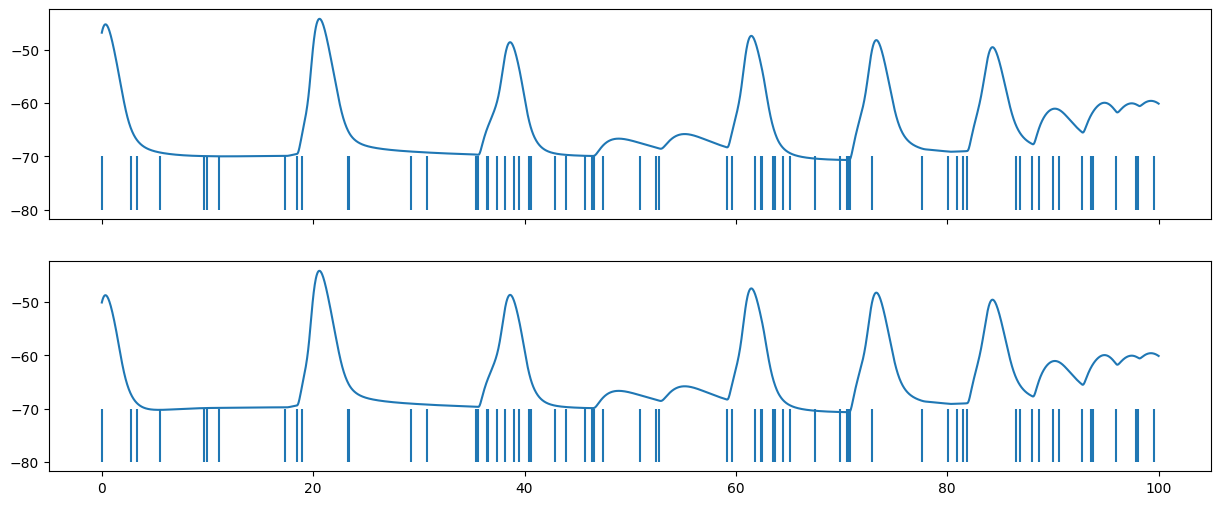

In [9]:
# troubleshoot single instance
reconstruct_duration = 100
ind = 15
starting_spike = spikes[ind]
subsequent_stims = [stim for stim in stim_events if (stim[1] > starting_spike) and (stim[1] <= starting_spike+reconstruct_duration)]

events = [Event(
        _id=stim[0],
        t=stim[1]-starting_spike,
        tau=stim[2],
        rev_potential=stim[3],
        seg_ind=stim[4],
        weight=stim[5]
    ) for stim in subsequent_stims]

# get comparable df
start_ind = starting_spike * 40
stop_ind = (starting_spike + reconstruct_duration) * 40
comparable_obvs_window = obv_v[:, round(start_ind):round(stop_ind+1)]

re_df = event_sim_reconstruct(events, starting_spike, reconstruct_duration, history=spiking_history)
#re_df = event_sim_reconstruct(events, reconstruct_duration)
re_df = np.array([list(vec) for vec in re_df])


print(comparable_obvs_window.shape)
print(re_df.shape)

_t = np.arange(0,100.025,1/40)

fig, axes = plt.subplots(2,1,figsize=(15,6), gridspec_kw={'height_ratios': [3, 3]}, sharex=True)
axes[0].plot(_t, comparable_obvs_window[100])
axes[0].vlines([event.t for event in events], -80, -70)

axes[1].plot(_t, re_df[100])
axes[1].vlines([event.t for event in events], -80, -70)

## running experiment

In [10]:
reconstruct_duration = 100
n = 100 # number of spikes to reconstruct
viable_spikes = [spike for spike in spikes if spike < max_time - reconstruct_duration]
spike_inds = np.random.choice(np.arange(0, len(viable_spikes)), n, replace=False)

reconstructed_dfs = []
comparable_obvs_dfs = []

print('______PROGRESS______')
progress = 0.0
for i, ind in enumerate(spike_inds):
    starting_spike = spikes[ind]
    subsequent_stims = [stim for stim in stim_events if (stim[1] > starting_spike) and (stim[1] <= starting_spike+reconstruct_duration)]

    events = [Event(
            _id=stim[0],
            t=stim[1]-starting_spike,
            tau=stim[2],
            rev_potential=stim[3],
            seg_ind=stim[4],
            weight=stim[5]
        ) for stim in subsequent_stims]

    # get comparable df
    start_ind = starting_spike * 40
    stop_ind = (starting_spike + reconstruct_duration) * 40
    comparable_obvs_window = obv_v[:, round(start_ind):round(stop_ind+1)]

    re_df = event_sim_reconstruct(events, starting_spike, reconstruct_duration, history=spiking_history)
    #re_df = event_sim_reconstruct(events, reconstruct_duration)
    re_df = np.array([list(vec) for vec in re_df])
    
    reconstructed_dfs.append(re_df)
    comparable_obvs_dfs.append(comparable_obvs_window)
    
    if i/n > progress:
        print('=',end='')
        progress+=0.05

______PROGRESS______

In [11]:
reconstructed_dfs[0][0,:].shape

(4001,)

In [12]:
comparable_obvs_dfs[0][0,:].shape

(4001,)

## convert all vectors to np mats

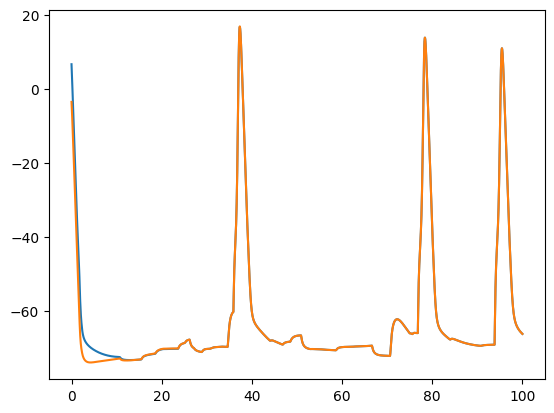

In [13]:
ind = 10
plt.plot(_t, comparable_obvs_dfs[ind][0,:])
plt.plot(_t, reconstructed_dfs[ind][0,:])
plt.show()

## get the distances

In [14]:
difs = []
for ind in range(n):
    difs.append(comparable_obvs_dfs[ind] - reconstructed_dfs[ind])
difs[0].shape

(784, 4001)

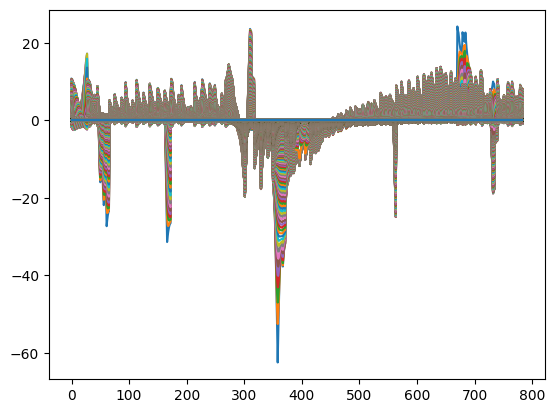

In [15]:
# TODO: this but ordered by distance from soma
plt.plot(difs[0])

plt.show()

## average difs by time

In [16]:
all_segs = [seg for sec in pyr.all for seg in sec]
soma_segs = [(i,seg) for i, seg in enumerate(all_segs) if 'soma' in str(seg.sec) ]
axon_segs = [(i,seg) for i, seg in enumerate(all_segs) if 'axon' in str(seg.sec) ]
dend_segs = [(i,seg) for i, seg in enumerate(all_segs) if 'dend' in str(seg.sec) ]
apic_segs = [(i,seg) for i, seg in enumerate(all_segs) if 'apic' in str(seg.sec) ]

In [17]:
# calculate the errors
difs = np.stack(difs)
print(difs.shape)

# and absolute errors
abs_difs = np.abs(difs)

(100, 784, 4001)


In [18]:
mean_difs_by_time = np.mean(abs_difs, axis=1)
mean_difs_by_time.shape

(100, 4001)

In [19]:
mean_difs_by_seg = np.mean(abs_difs, axis=2)
mean_difs_by_seg.shape

(100, 784)

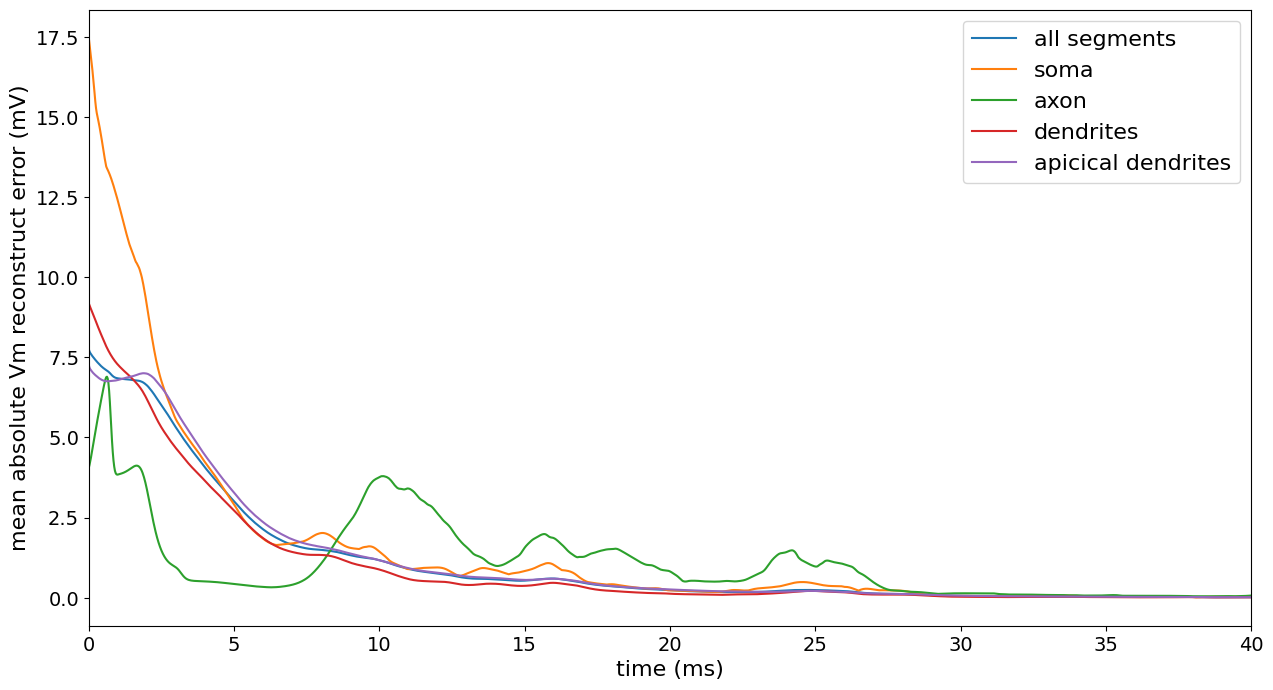

In [20]:
plt.figure(figsize=(15,8))

# all segs
plt.plot(_t, np.mean(mean_difs_by_time, axis=0))

# soma segs
soma_difs = abs_difs[:,[x[0] for x in soma_segs],:]
mean_soma_difs_by_time = np.mean(soma_difs, axis=1)
plt.plot(_t, np.mean(mean_soma_difs_by_time, axis=0))

# axon segs
axon_difs = abs_difs[:,[x[0] for x in axon_segs],:]
mean_axon_difs_by_time = np.mean(axon_difs, axis=1)
plt.plot(_t, np.mean(mean_axon_difs_by_time, axis=0))

# dend segs
dend_difs = abs_difs[:,[x[0] for x in dend_segs],:]
mean_dend_difs_by_time = np.mean(dend_difs, axis=1)
plt.plot(_t, np.mean(mean_dend_difs_by_time, axis=0))

# apic segs
apic_difs = abs_difs[:,[x[0] for x in apic_segs],:]
mean_apic_difs_by_time = np.mean(apic_difs, axis=1)
plt.plot(_t, np.mean(mean_apic_difs_by_time, axis=0))


plt.ylabel('mean absolute Vm reconstruct error (mV)', fontsize=16)
plt.xlabel('time (ms)', fontsize=16)
plt.xlim(0,40)

plt.legend(['all segments','soma','axon','dendrites','apicical dendrites'], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

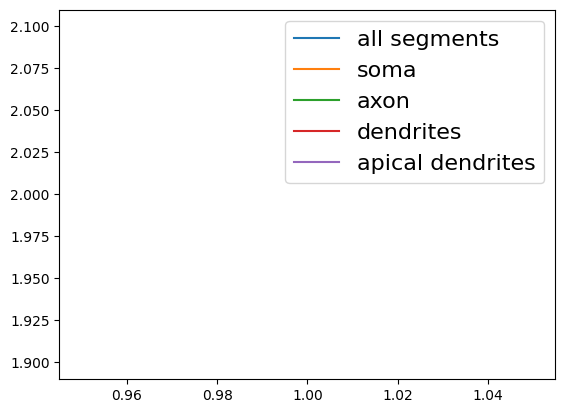

In [21]:
plt.plot(1,2)
plt.plot(1,2)
plt.plot(1,2)
plt.plot(1,2)
plt.plot(1,2)
plt.legend(['all segments','soma','axon','dendrites','apical dendrites'], fontsize=16)

In [22]:
def seg2color(seg):
    if 'soma' in str(seg):
        return 'orange'
    elif 'axon' in str(seg):
        return 'green'
    elif 'dend' in str(seg):
        return 'red'
    elif 'apic' in str(seg):
        return 'purple'
    else:
        return 'error'


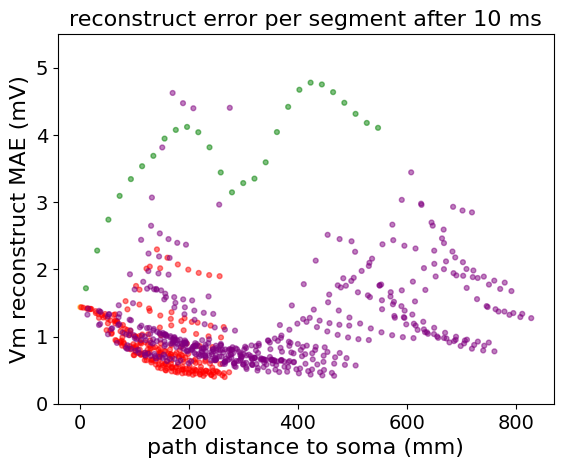

In [23]:
t = 10
plt.scatter(
    [h.distance(seg, pyr.soma[0](0.5)) for sec in pyr.all for seg in sec], 
    np.mean(abs_difs[:,:,t*40], axis=0), #np.mean(mean_difs_by_seg, axis=0)
    color=[seg2color(seg) for seg in all_segs],
    s=12,
    alpha=0.5
)
plt.ylim(0, 5.5)

plt.title(f'reconstruct error per segment after {t} ms', fontsize=16)
plt.ylabel('Vm reconstruct MAE (mV)', fontsize=16)
plt.xlabel('path distance to soma (mm)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

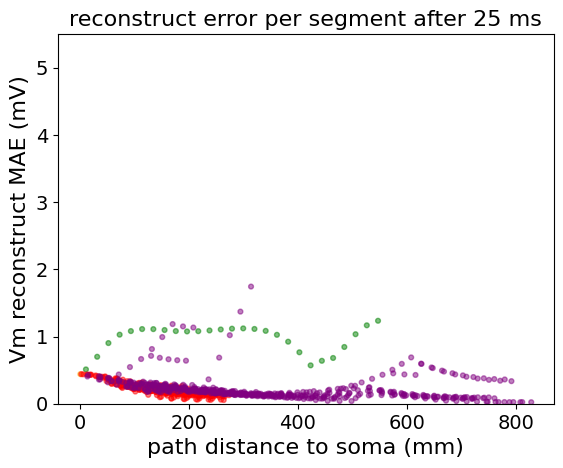

In [24]:
t = 25
plt.scatter(
    [h.distance(seg, pyr.soma[0](0.5)) for sec in pyr.all for seg in sec], 
    np.mean(abs_difs[:,:,t*40], axis=0), #np.mean(mean_difs_by_seg, axis=0)
    color=[seg2color(seg) for seg in all_segs],
    s=12,
    alpha=0.5
)
plt.ylim(0, 5.5)

plt.title(f'reconstruct error per segment after {t} ms', fontsize=16)
plt.ylabel('Vm reconstruct MAE (mV)', fontsize=16)
plt.xlabel('path distance to soma (mm)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [25]:
np.max(np.mean(abs_difs[:,:,800], axis=0))

2.6059859287775997

In [26]:
np.mean(abs_difs[:,:,800], axis=0).shape

(784,)

## 3D visualization

In [27]:
from neuron import rxd
cyt = rxd.Region(pyr.all)
error = rxd.Parameter(cyt)
'''
for node in error.nodes:
    node.value = h.distance(node.segment, pyr.soma[0](0.5))
'''

i = 0
vals = []
for sec in pyr.all:
    for seg in sec:
        #error.nodes(seg).value = h.distance(seg, pyr.soma[0](0.5))
        #error.nodes(seg).value = np.mean(mean_difs_by_seg, axis=0)[i]
        error.nodes(seg).value = np.mean(abs_difs[:,:,800], axis=0)[i]
        vals.append(np.mean(abs_difs[:,:,800], axis=0)[i])
        
        #print(seg, np.mean(abs_difs[:,:,800], axis=0)[i])
        i+=1

In [31]:
ps = h.PlotShape(False)
ps.variable(error)
ps.scale(0, 1)

ps2 = ps.plot(plotly, cmap=cm.cool)

for seg_ind in stimuli:
    seg = pyr.all_input_segments[int(seg_ind)]
    ps2.mark(seg, marker_size=3, marker_color=event_type2color(stimuli[seg_ind]._id), marker_opacity=.9)

ps2.show()

ImportError: Please install ipywidgets>=7.0.0 to use the FigureWidget class

In [ ]:
max(vals)

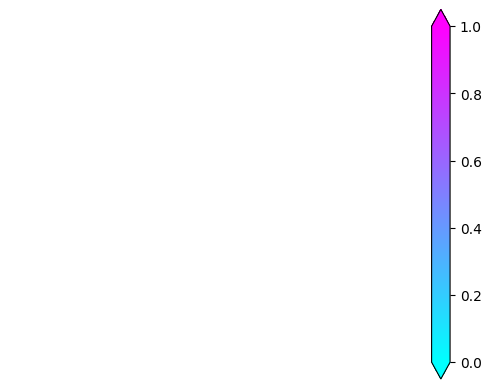

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='cool'),
            ax=ax, extend='both')

ax.axis('off')
plt.show()